In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from tensorflow.keras.optimizers import SGD 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import math
from sklearn.metrics import mean_squared_error

# Data Preparation

In [2]:
stock = pd.read_csv(r"D:\Bootcamp data scientist\Final Project\Template Project\Template Project Data Science\Case Study 04\all_stocks_2006-01-01_to_2018-01-01.csv")
stock

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,77.76,79.35,77.24,79.11,3117200,MMM
1,2006-01-04,79.49,79.49,78.25,78.71,2558000,MMM
2,2006-01-05,78.41,78.65,77.56,77.99,2529500,MMM
3,2006-01-06,78.64,78.90,77.64,78.63,2479500,MMM
4,2006-01-09,78.50,79.83,78.46,79.02,1845600,MMM
...,...,...,...,...,...,...,...
93607,2017-12-22,71.42,71.87,71.22,71.58,10979165,AABA
93608,2017-12-26,70.94,71.39,69.63,69.86,8542802,AABA
93609,2017-12-27,69.77,70.49,69.69,70.06,6345124,AABA
93610,2017-12-28,70.12,70.32,69.51,69.82,7556877,AABA


In [3]:
stock_mmm = stock[stock["Name"] == "MMM"]
mmm=stock_mmm.drop('Name',axis=1)
mmm

,Date,Open,High,Low,Close,Volume
0,2006-01-03,77.76,79.35,77.24,79.11,3117200
1,2006-01-04,79.49,79.49,78.25,78.71,2558000
2,2006-01-05,78.41,78.65,77.56,77.99,2529500
3,2006-01-06,78.64,78.90,77.64,78.63,2479500
4,2006-01-09,78.50,79.83,78.46,79.02,1845600
...,...,...,...,...,...,...
3015,2017-12-22,235.36,236.08,234.28,234.73,1280557
3016,2017-12-26,235.08,236.28,235.03,235.45,789090
3017,2017-12-27,235.52,236.54,234.84,236.20,970508
3018,2017-12-28,236.94,237.08,235.28,235.72,1189738


## Membuat Format Datetime

In [4]:
mmm['Date'] = pd.to_datetime(mmm.Date)
mmm = mmm.set_index(mmm.Date)
mmm.drop('Date', axis = 1, inplace = True)
print('Column datatypes= \n',mmm.dtypes)
mmm

Column datatypes= 
 Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object


,Open,High,Low,Close,Volume
Date,,,,,
2006-01-03,77.76,79.35,77.24,79.11,3117200
2006-01-04,79.49,79.49,78.25,78.71,2558000
2006-01-05,78.41,78.65,77.56,77.99,2529500
2006-01-06,78.64,78.90,77.64,78.63,2479500
2006-01-09,78.50,79.83,78.46,79.02,1845600
...,...,...,...,...,...
2017-12-22,235.36,236.08,234.28,234.73,1280557
2017-12-26,235.08,236.28,235.03,235.45,789090
2017-12-27,235.52,236.54,234.84,236.20,970508


In [5]:
# Membuat plot Prediksi
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real MMM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted MMM Stock Price')
    plt.title('MMM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('MBM Stock Price')
    plt.legend()
    plt.show()

#Mengevaluasi modelnya
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

## Memasukkan data training dan testing

In [6]:
# Checking for missing values
training_set = mmm[:'2016'].iloc[:,3:4].values
test_set = mmm['2017':].iloc[:,3:4].values
training_set 

array([[ 79.11],
       [ 78.71],
       [ 77.99],
       ...,
       [178.08],
       [178.41],
       [178.57]])

## Plotting

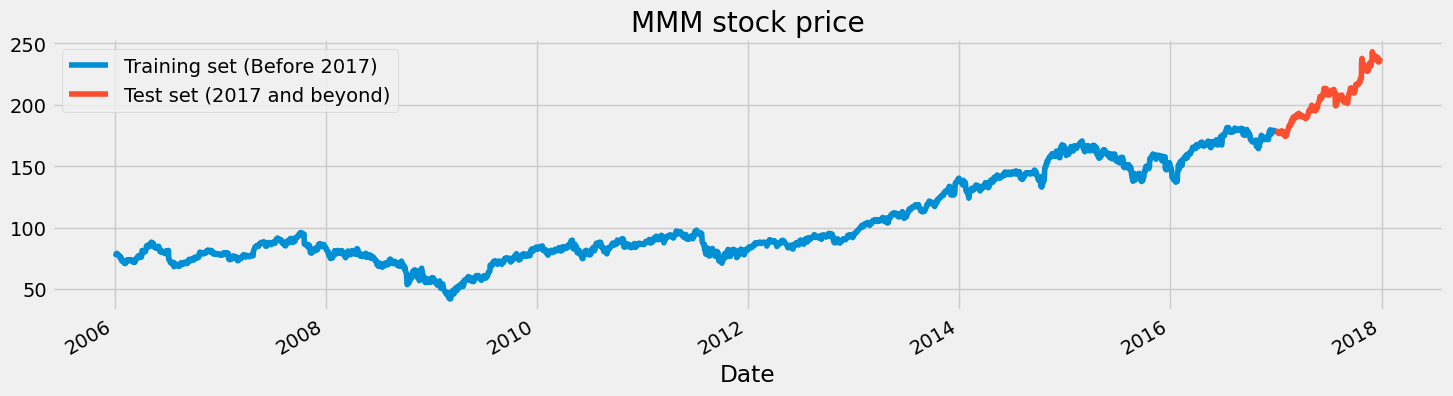

In [7]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
mmm['Close'][:'2016'].plot(figsize=(16,4),legend=True)
mmm['Close']['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('MMM stock price')
plt.show()

Disini terlihat bahwa data harga saham mmm mengalami trend naik

## Scalling data training

In [8]:
# preprocessor=preprocessing.MinMaxScaler(feature_range=(0,1))
# sc=preprocessor.fit_transform(training_set)
# sc

In [9]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [10]:
X_train = []
y_train = []
for i in range(60,2769):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [11]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

# LSTM (Long Short Term Memory)

Variabel units mengindikasikan jumlah unit (neuron) dalam lapisan LSTM tersebut. Dalam proyek ini, terdapat 50 unit.

return_sequences mengatur apakah lapisan LSTM ini akan mengembalikan urutan penuh dari output atau hanya output terakhir. Jika True, maka output dari setiap timestep di sepanjang sekuens akan dikembalikan. Jika False, hanya output terakhir yang akan dikembalikan.

input_shape menentukan bentuk data input ke lapisan ini.jika memiliki data time series dengan 10 timestep, maka X_train.shape[1] akan bernilai 10, dan (X_train.shape[1], 1) berarti bahwa tiap sekuens memiliki 10 timestep dengan satu fitur per timestep.

activation mengatur fungsi aktivasi yang digunakan di dalam lapisan GRU ini. tanh (tangens hiperbolik) adalah fungsi aktivasi yang umum digunakan pada jaringan RNN, karena membantu mengatur nilai output antara -1 dan 1, yang membantu mengurangi efek eksploding dan vanishing gradients pada pelatihan jaringan syaraf yang mendalam.

Penggunaan dropout dengan rate tertentu (misalnya, 0.2 berarti 20% neuron dihapus secara acak selama pelatihan) membantu mengurangi risiko overfitting dengan memberikan regularisasi.

4 lapisan (layer) GRU menandakan bahwa model ini memiliki struktur berlapis (multi-layer). Di jaringan berlapis seperti ini, output dari lapisan pertama menjadi input untuk lapisan berikutnya. Tidak ada kriteria khusus untuk jumlah lapisan

In [14]:
import tensorflow as tf
import numpy as np
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

# Set seed untuk konsistensi output
seed_value = 42
tf.random.set_seed(seed_value)  # Mengatur seed untuk TensorFlow
np.random.seed(seed_value)  # Mengatur seed untuk NumPy
random.seed(seed_value)  # Mengatur seed untuk Python `random`

# The LSTM architecture
model_lstm = Sequential()
# First LSTM layer with Dropout regularisation
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model_lstm.add(Dropout(0.2))
# Second LSTM layer
model_lstm.add(LSTM(units=50, return_sequences=True))
model_lstm.add(Dropout(0.2))
# Third LSTM layer
model_lstm.add(LSTM(units=50, return_sequences=True))
model_lstm.add(Dropout(0.2))
# Fourth LSTM layer
model_lstm.add(LSTM(units=50))
model_lstm.add(Dropout(0.2))
# The output layer
model_lstm.add(Dense(units=1))

# Set seed untuk konsistensi output
seed_value = 42
tf.random.set_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)

# Compiling the RNN
model_lstm.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
model_lstm.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 18s 112ms/step - loss: 0.0423
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - loss: 0.0075
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - loss: 0.0062
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - loss: 0.0054
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - loss: 0.0040
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - loss: 0.0038
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - loss: 0.0032
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - loss: 0.0038
Epoch 9/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - loss: 0.0036
Epoch 10/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - loss: 0.0030
Epoch 11/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - loss: 0.0029
Epoch 12/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - loss: 0.0025
Epoch 13/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - loss: 0.0026
Epoch 14/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - loss: 0.0022
Epoch 15/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 

In [15]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((mmm["Close"][:'2016'],mmm["Close"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [16]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = model_lstm.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step


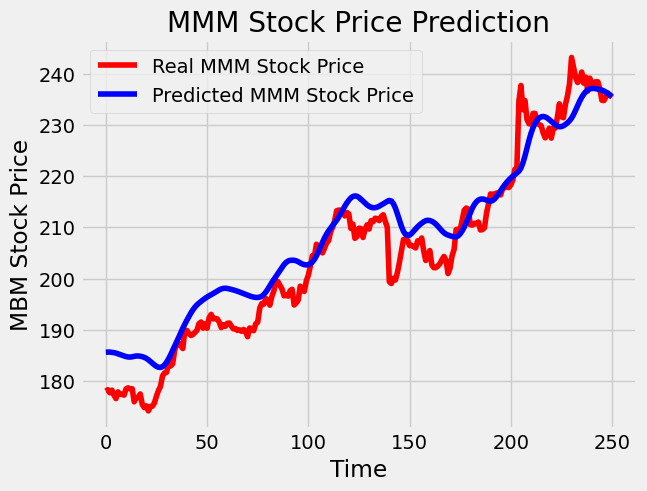

In [17]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

Berdasarkan hasil visualisasinya, terlihat bahwa nilai stock price hasil prediksi dan nilai aktualnya hampir mendekati. Secara visual metode ini dapat melakukan prediksi dengan baik. Namun kita perlu menguji secara formal untuk hasil yang lebih terukur, karena interpretasi setiap orang terhadap gambar berbeda. Pengujian formal dilakukan dengan menghitung RMSE

In [18]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 5.451685159845753.


# (GRU) Gated Recurrent Units

GRU (Gated Recurrent Unit), sebuah jenis jaringan syaraf yang umum digunakan untuk data sekuensial, seperti seri waktu (time series) atau teks. GRU mirip dengan LSTM tetapi dengan struktur yang lebih sederhana. <br>

Variabel units mengindikasikan jumlah unit (neuron) dalam lapisan GRU tersebut. Dalam proyek ini, terdapat 50 unit. 

return_sequences mengatur apakah lapisan GRU ini akan mengembalikan urutan penuh dari output atau hanya output terakhir. Jika True, maka output dari setiap timestep di sepanjang sekuens akan dikembalikan. Jika False, hanya output terakhir yang akan dikembalikan. 

input_shape menentukan bentuk data input ke lapisan ini.jika memiliki data time series dengan 10 timestep, maka X_train.shape[1] akan bernilai 10, dan (X_train.shape[1], 1) berarti bahwa tiap sekuens memiliki 10 timestep dengan satu fitur per timestep.

activation mengatur fungsi aktivasi yang digunakan di dalam lapisan GRU ini. tanh (tangens hiperbolik) adalah fungsi aktivasi yang umum digunakan pada jaringan RNN, karena membantu mengatur nilai output antara -1 dan 1, yang membantu mengurangi efek eksploding dan vanishing gradients pada pelatihan jaringan syaraf yang mendalam.

Penggunaan dropout dengan rate tertentu (misalnya, 0.2 berarti 20% neuron dihapus secara acak selama pelatihan) membantu mengurangi risiko overfitting dengan memberikan regularisasi.

4 lapisan (layer) GRU menandakan bahwa model ini memiliki struktur berlapis (multi-layer). Di jaringan berlapis seperti ini, output dari lapisan pertama menjadi input untuk lapisan berikutnya. Tidak ada kriteria khusus untuk jumlah lapisan

In [19]:
# The GRU architecture
LSTM_GRU = Sequential()
# First GRU layer with Dropout regularisation
LSTM_GRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
LSTM_GRU.add(Dropout(0.2))
# Second GRU layer
LSTM_GRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
LSTM_GRU.add(Dropout(0.2))
# Third GRU layer
LSTM_GRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
LSTM_GRU.add(Dropout(0.2))
# Fourth GRU layer
LSTM_GRU.add(GRU(units=50, activation='tanh'))
LSTM_GRU.add(Dropout(0.2))
# The output layer
LSTM_GRU.add(Dense(units=1))
# Compiling the RNN
LSTM_GRU.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
LSTM_GRU.fit(X_train,y_train,epochs=50,batch_size=150)

C:\Users\alfar\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50


C:\Users\alfar\AppData\Roaming\Python\Python311\site-packages\keras\src\optimizers\base_optimizer.py:32: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 323ms/step - loss: 0.1462
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 327ms/step - loss: 0.0381
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 338ms/step - loss: 0.0125
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 331ms/step - loss: 0.0039
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 332ms/step - loss: 0.0033
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 324ms/step - loss: 0.0028
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 331ms/step - loss: 0.0028
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 336ms/step - loss: 0.0026
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 340ms/step - loss: 0.0026
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 339ms/step - loss: 0.0023
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 338ms/step - loss: 0.0026
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 327ms/step - loss: 0.0025
Epoch 13/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 328ms/step - loss: 0.0022
Epoch 14/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 336ms/step - loss: 0.0019
Epoch 15/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 322ms/step - loss: 0.0023

Model GRU telah berhasil mempelajari pola dari data pelatihan, dengan nilai loss yang terus menurun. Namun, perlu dicatat bahwa penurunan nilai loss tidak selalu berarti bahwa model akan bekerja dengan baik pada data yang tidak terlihat (data validasi atau pengujian). Oleh karena itu, langkah selanjutnya adalah mengevaluasi model ini pada data testing dan prediction untuk memastikan kemampuannya dalam generalisasi dan menghindari overfitting.

In [20]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = LSTM_GRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step


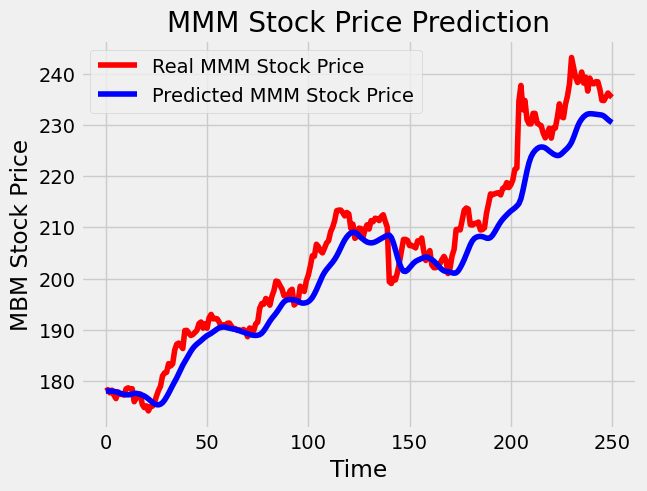

In [21]:
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

Berdasarkan hasil visualisasinya, terlihat bahwa nilai stock price hasil prediksi dan nilai aktualnya hampir mendekati. Perbedaannya juga lebih tipis daripada model LSTM sebelumnya. Secara visual metode ini dapat melakukan prediksi dengan baik. Namun kita perlu menguji secara formal untuk hasil yang lebih terukur, karena interpretasi setiap orang terhadap gambar berbeda.

In [22]:
# Evaluating GRU
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 5.44315981932946.


Nilai RMSE dari model GRU lebih kecil dari pada model LSTM. Hal ini berarti model GRU lebih akurat dalam memprediksi pola data MMM Stock Price